<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forked again from segmentation_keras_refactor; using segmentation_models, based on the code elizabeth shared with matt

# Init Segmentation

## Mount Google Drive, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
try:
    in_colab = True
    from google.colab import drive
    drive.mount('/content/gdrive',force_remount=True);
except ImportError:
    in_colab = False

### Installing and loading packages

In [2]:
%pip show keras
%pip show torch

Name: keras
Version: 3.9.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: C:\Users\miner\miniconda3\envs\segmentation\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow-intel
Note: you may need to restart the kernel to use updated packages.
Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\miner\miniconda3\envs\segmentation\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: fastai, torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [3]:
%%capture
# %pip install segmentation-models
# %pip install imageio --upgrade
# %pip install json-tricks
# %pip install ultraimport
# %pip install joblib
# %pip install ray

### Import libraries

In [4]:
import pandas as pd
from warnings import warn
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity, adjust_gamma
from skimage.transform import resize
from typing import Callable,Dict,List,Tuple,Union,Any,Iterable
from tqdm import tqdm
import os
import numpy as np
from pathlib import Path
import re
import ntpath
import shutil
import stat
import json_tricks
import ultraimport
if in_colab:
    filenames = ultraimport('/content/gdrive/Othercomputers/UNC Laptop/libraries/filenames.py')
else:
    filenames = ultraimport('libraries/filenames.py')

# fix for new segmentation_models error was taken from here: https://stackoverflow.com/questions/75433717/module-keras-utils-generic-utils-has-no-attribute-get-custom-objects-when-im
os.environ["KERAS_BACKEND"] = "torch"
os.environ["SM_FRAMEWORK"] = "keras"
from segmentation_models import Unet
from keras.preprocessing.image import load_img
import keras
import random



Segmentation Models: using `keras` framework.


In [5]:
import torch
torch.cuda.is_available()

False

## Segmentation Parameters


### Basic Parameters
other shared settings between training and separation

In [171]:
#@markdown ### To specify a file in a bucket, prexis the path with gs://
#@markdown Whether input paths exist in a gcp bucket (will be autodetected if unset)
activate_gcp = False #@param {type:"boolean"}

def is_gcp_path(path:Path):
  return path.parts[0].lower() == "gs:";

#@markdown What object type you are segmenting
segmentation_target = "Cell" #@param ["Nucleus", "Cell", "Combined"]

#@markdown folder where processed images will be stored for training or segmentation
local_folder='local' #@param {type:"string"}
local_folder=Path(local_folder);

#@markdown folder where image processing metadata is stored
meta_folder = 'meta' #@param {type:"string"}
meta_folder = Path(meta_folder)

#@markdown folder where downloaded images will be stored temporarily for processing
temp_folder='temp' #@param {type:"string"}
temp_folder = Path(temp_folder);

#@markdown directory where models are stored and will be exported to
_modelsfolder = 'gs://optotaxisbucket/models/keras' #@param {type:"string"}
_modelsfolder = Path(_modelsfolder);
if is_gcp_path(_modelsfolder):
  activate_gcp = True;


training_images_folder = local_folder/"train_images"
training_masks_folder = local_folder/"train_masks"
segmentation_images_folder = local_folder/"segmentation_images"
segmentation_output_folder = local_folder/"segmentation_masks_out"
local_modelsfolder = local_folder/"models";


local_folders = [local_folder,
            training_images_folder,
            training_masks_folder,
            segmentation_images_folder,
            segmentation_output_folder,
            local_modelsfolder,
            temp_folder];

def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )

def cleardir(dir): #clears all files in dir without deleting dir
  print("dir cleared:",dir)
  for f in os.scandir(dir):
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);


for d in local_folders:
  if not os.path.exists(d):
    os.makedirs(d);
  else:
    cleardir(d);


dir cleared: local
dir cleared: temp


### Image Preparation Settings
shared settings between training and segmentation image/mask processing

In [172]:
#@markdown ##Adjacent Image Stacking
#@markdown Whether to use several "adjacent" images as input instead of one
image_stacking = True #@param {type:"boolean"}
num_stacked_images = 3 #@param {type:"integer"}

#@markdown ### Mask stacking
#@markdown Whether to also train (and output) a mask for each input image, or just use the center.
#@markdown "Narrow" means only the center mask will be used. This cuts off the end and the beginning of the movie, depending on the width of stacking.
#@markdown "Wide" means a mask will be segmented for every image. This means there will be multiple corresponding masks per image! When segmenting in this notebook, they will be labeled by offset number in the output directory.
mask_stacking_type = "Narrow" #@param ["Narrow", "Wide"]
mask_stacking = (mask_stacking_type == "Wide")


#@markdown Scale factor - factor by which height and width will be multiplied, final dimensions rounded to nearest integer. (Default is 1, which does nothing)
scale_factor = 1 #@param {type:"number"}

do_scaling = scale_factor == 1


#@markdown ##Image Splitting and stitching
#@markdown Whether to split trained images into smaller chunks
do_splitting = False #@param {type:"boolean"}

#@markdown Number of slices (columns/rows) to divide input images into; for the math, please see https://www.desmos.com/calculator/xrqev2vluo
x_slices = 4 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  32#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

if not do_splitting:
  x_slices = 1;
  y_slices = 1;
  dx = 0;
  dy = 0;
  x_crop = 0;
  y_crop = 0;

context_bounds = [dy,dx]*2 #assuming x and y bounds are symmetrical to both sides of the image, which might not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

### Training-Specific Settings
parameters and paths only for training

In [173]:
#@markdown ## Training Source
#@markdown location - zip file or folder - where input images are stored
# _training_images="/content/gdrive/Othercomputers/UNC Laptop/iter1/round11/wide_images" #@param {type:"string"}
_training_images="C:/Users/miner/OneDrive - University of North Carolina at Chapel Hill/Bear Lab/optotaxis calibration/data/segmentation_iteration_testing/iter4/round1/wide_images" #@param {type:"string"}
_training_images=Path(_training_images);

#@markdown input folder where masks are stored (will not be edited)
_training_masks="C:/Users/miner/OneDrive - University of North Carolina at Chapel Hill/Bear Lab/optotaxis calibration/data/segmentation_iteration_testing/iter4/round1/masks" #@param {type:"string"}
_training_masks=Path(_training_masks);

if (is_gcp_path(_training_images) or is_gcp_path(_training_masks)):
  activate_gcp = True;

#@markdown UNET model that will be used to train from, relative to modelsfolder. if left blank, a new model will be created (customizable in the cell in training.)
inmodelname = '' #@param {type:"string"}
#@markdown Name of the output model will be exported to after training, in modelsfolder (if modelsfolder is gcp, will also update)
outmodelname = 'iter4_1_3stack_cell_nosplit' #@param {type:"string"}

#@markdown ## Training Data Augmentation

#@markdown ### Gamma (avg brightness) adjustments
do_gamma = False #@param {type:"boolean"}
gamma_aug_list = [0.5,0.8,1,1.2,1.5] #@param {type:"raw"}

#@markdown whether to have the model output at half resolution (only applies to newly created models)
model_halfres = False #@param {type:"boolean"}

#@markdown Mask Scale Factor - if input mask needs to be scaled by a different factor than input image, add it here. Multiplies with the overall factor. 1 keeps default behavior.
train_mask_scale_factor = 1 #@param {type:"number"}


### Segmentation-Specific Settings
parameters and paths only for segmenting an experiment


In [174]:
#@markdown Path of the folder containing the movies in GCP bucket
_segmentation_images="gs://optotaxisbucket/movies/2024.6.27 OptoPLC FN+Peg Test 3/2024.6.27 OptoPLC FN+Peg Test 3"  #@param {type:"string"}
# _segmentation_images=r"C:\Users\miner\OneDrive - University of North Carolina at Chapel Hill\Bear Lab\optotaxis calibration\data\segmentation_iteration_testing\Evaluation Input Images\nosplit_wide"  #@param {type:"string"}
_segmentation_images=Path(_segmentation_images);

#@markdown name of the model used to segment. Can be specified as a tuple of models to be applied sequentially and sent to multiple output subfolders
segment_model_name = "iter4_1_3stack_cell" #@param

#@markdown path of the folder where the output masks will be deposited. if in gcp bucket (prefix with gs://), will be exported
_segmentation_output_masks='gs://optotaxisbucket/movie_segmentation/2024.6.27 OptoPLC FN+Peg Test 3/Cell' #@param {type:"string"}
# _segmentation_output_masks=r'C:\Users\miner\OneDrive - University of North Carolina at Chapel Hill\Bear Lab\optotaxis calibration\data\movie_segmentation\2024.6.27 OptoPLC FN+Peg Test 4\Cell' #@param {type:"string"}
_segmentation_output_masks=Path(_segmentation_output_masks);

if is_gcp_path(_segmentation_images) or is_gcp_path(_segmentation_output_masks):
  activate_gcp = True;

#@markdown if the output of the segmentation needs to be scaled up/down by a certian factor, put it here.
segmentation_mask_scale_factor = 1 #@param {type:"number"}

#@markdown For stacking: whether to attempt to segment the beginning/end of the movie by duplicating the ends
segmentation_stacking_dup_ends = True #@param {type:"bool"}



### Activate GCP if necessary

In [175]:
if activate_gcp:
    if in_colab:
        from google.colab import auth
        #This allows SDK to see and edit Google Drive files
        #SDK is required to interact with GCP
        auth.authenticate_user()
    else: #if we're local, we shouldn't need to reauth
        pass


## Shared helper functions

### Model Management

In [176]:
#### KERAS ####
if True:
    def create_UNET():
        return Unet('resnet34', encoder_weights='imagenet', classes=2, input_shape=(None,None,3), activation='softmax')

    def load_model(modelname:str|Path,fetch=True):
        # json_name = local_modelsfolder/modelname/('model_config.json')
        # weights_name = local_modelsfolder/modelname/('weights_only.h5')
        # if fetch:
        #     fetch_modelsfolder()
        # return load_keras_h5(json_name,weights_name)

        #Keras 3 loading - just use keras.saving.load_model
        if fetch:
            fetch_modelsfolder()
        return keras.saving.load_model(local_modelsfolder/f"{modelname}.keras")

    # def load_keras_h5(config_path:Path,weights_path:Path):
    #     #load model as json
    #     with open(config_path) as json_file:
    #         json_config = json_file.read()
    #     loaded_model = keras.models.model_from_json(json_config)

    #     # Load weights
    #     loaded_model.load_weights(weights_path)

    #     return loaded_model

    def save_model(modelname:str|Path,model,push=True):
        # json_name = local_modelsfolder/modelname/('model_config.json')
        # weights_name = local_modelsfolder/modelname/('weights_only.h5')

        # # Save model config
        # json_config = model.to_json()
        # with open(json_name, 'w') as json_file:
        #     json_file.write(json_config)

        # # Save weights and architecture
        # model.save_weights(weights_name)

        # if push:
        #     push_modelsfolder()

        #Keras 3 saving - just use keras.saving.save_model.
        import keras
        keras.saving.save_model(model,local_modelsfolder/f"{modelname}.keras")

        if push:
            push_modelsfolder()

#### PYTORCH ####
#idk if I'm ever gonna use this but this is where you'd implement similar functions
if False:
    pass

### File Transfer / Management

In [177]:
from collections import OrderedDict
from copy import deepcopy
from pathlib import PurePosixPath

def _fetch_gcp_files(in_path:Path,keyword:str,overwrite:bool)->Path: ##should not be called outside of other helper functions
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  destination = temp_folder/keyword/in_path.stem;
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  # copy_out = Path(destination)/in_path.name;
  command_output = None;
  if (is_gcp_path(in_path)): #first part is gs:, must be removed to work with gcloud
    in_path = PurePosixPath(*in_path.parts[1:])
  if overwrite or len(os.listdir(destination)) == 0:
    if is_file:
      command_output = !gsutil -m cp -r "gs://{in_path}" "{destination}"
    else:
      command_output = !gsutil -m rsync -r "gs://{in_path}" "{destination}"
  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while downloading {keyword} from bucket: " + '\n'.join(command_output));
  elif len(os.listdir(destination)) == 0:
    raise RuntimeError("Error: downloading failed for an unknown reason, 0 files in dest directory; Command Output:",command_output);
  if (not is_file):
    return destination; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      command_output = !unzip -o "{destination}" -d "{destination.parent}"
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + '\n'.join(command_output));
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error while unzipping (from GCP): zip file {destination.name} does not contain folder {destination.with_suffix('').name}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");

def _push_gcp_files(in_folder:Path,out_path:Path,keyword:str,overwrite:bool):
  print(in_folder,out_path)
#   breakpoint()
  assert os.path.isdir(in_folder);
  if (is_gcp_path(out_path)): #first part is gs:, must be removed to work with gcloud
    out_path = PurePosixPath(*out_path.parts[1:])

  command_output = None;

  if (out_path.suffix != ''): #file
    in_file = None;
    if (out_path.suffix.lower() == '.zip'):
      command_output = !zip "{temp/keyword/zip/out_path.name}"  "{in_folder}"
      if (command_output is not None and command_output[0].startswith("CommandException")):
        raise RuntimeError(f"Error while zipping {keyword} folder {in_folder} to zip file: " + '\n'.join(command_output));
      in_file = temp_folder/keyword/zip/out_path.name;
    elif (out_path.suffix.lower().startswith('.tif')):
      raise NotImplementedError("stacking TIF files not yet supported");
    else:
      raise NameError("Invalid output suffix; can only zip or stack tiffs. If the output is a directory, please do not add a file suffix.")

    if overwrite:
      command_output = !gsutil -m cp -r "{in_file}" "gs://{out_path}"
    else:
      command_output = !gsutil -m cp -r -n "{in_file}" "gs://{out_path}"
  else: #upload entire directory
    command_output = !gsutil -m rsync -r "{in_folder}" "gs://{out_path}"

  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while uploading {keyword} to bucket: " + '\n'.join(command_output));
  return


In [178]:
_keyword_map = {"models":(_modelsfolder,local_modelsfolder),
               "train_images":(_training_images,training_images_folder),
               "train_masks":(_training_masks,training_masks_folder),
               "segmentation_images":(_segmentation_images,segmentation_images_folder),
               "segmentation_masks":(_segmentation_output_masks,segmentation_output_folder)};

_keyword_sources:Dict[str,Union[None,Path]] = {name:None for name in _keyword_map};


In [179]:
def _fetch_sourcefolder(keyword,overwrite=True)->Path:
  """returns the folder with the raw files, after unzip and or download if necessary."""
  if (not overwrite and _keyword_sources[keyword] is not None):
    return _keyword_sources[keyword];
  source = _keyword_map[keyword][0];
  result = source;
  if (is_gcp_path(source)):
    result = _fetch_gcp_files(source,keyword,overwrite=True);
  elif (source.suffix == '.zip'):
    destination = temp_folder/keyword;
    os.mkdir(destination);
    command_output = !unzip -o "{source}" -d "{destination}"
    result = destination/source.stem;
    if (not os.path.exists(result)):
      raise RuntimeError(f"Error while unzipping: zip file {source} does not contain folder {source.stem}");
  if (_keyword_sources[keyword] is not None and _keyword_sources[keyword] != result):
    raise RuntimeError(f"Error fetching sourcefolder for keyword {keyword}: sourcefolder already exists in a different location - are you pushing before you fetch?");
  _keyword_sources[keyword] = result;
  return result;

def _push_sourcefolder(keyword,overwrite=True):
  """inverse of fetch_sourcefolder - zips sourcefolder to original location or pushes to gcp if appropriate, otherwise noop"""
  sourcefolder = _keyword_sources[keyword];
  if (sourcefolder is None):
    raise RuntimeError("")
  dest = _keyword_map[keyword][0];
  if (is_gcp_path(dest)):
    _push_gcp_files(sourcefolder,dest,keyword,overwrite=overwrite);
  elif (dest.suffix == '.zip'):
    raise NotImplementedError("local sourcefolder zipping not implemented");
  pass;



class Img:
    name:str
    img:np.ndarray
    metadata:dict[str,Any]

    def __init__(self,name:str,img:np.ndarray,metadata:dict[str,Any]):
        self.name = name
        self.img = img
        self.metadata = metadata

    def copy(self):
        return Img(*self)

    def asdict(self):
        return {"name":self.name,"img":self.img,"metadata":self.metadata}

    def astuple(self):
        return (self.name,self.img,self.metadata)

    def __iter__(self):
        return iter(self.astuple())

    def __str__(self):
        return f"Image {self.name} of shape {self.img.shape} and metadata {list(self.metadata.keys())}"

_single_proc = Callable[[Img],Union[Img,Iterable[Img]]]
# _multi_proc =
proc_type = Callable[[Union[Img,Iterable[Img]]],Union[Img,Iterable[Img]]]

from functools import wraps
def doublewrap(f):
    '''
    a decorator decorator, allowing the decorator to be used as:
    @decorator(with, arguments, and=kwargs)
    or
    @decorator
    '''
    @wraps(f)
    def new_dec(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            # actual decorated function
            return f(args[0])
        else:
            # decorator arguments
            return lambda realf: f(realf, *args, **kwargs)

    return new_dec

from typing import DefaultDict,Dict,TypeVar
K = TypeVar('K')
V = TypeVar('V')
def merge_data(*dicts:Dict[K,V],require_all_present=True,require_all_equal=True)->Dict[K,V]:
    if not require_all_present:
        if not require_all_equal:
            dd = DefaultDict(list)
            for d in dicts: # you can list as many input dicts as you want here
                for key, value in d.items():
                    dd[key].append(value)
            return {k:v[0] for k,v in dd.items()}
        else:
            dd = {}
            null = object()
            for d in dicts:
                for key,value in d.items():
                    if key in dd:
                        if dd[key] is not null and dd[key] != value:
                            dd[key] = null
                    else:
                        dd[key] = value
            return {k:v for k,v in dd.items() if v is not null}

    else:
        if not require_all_equal:
            dd = {k:[] for k in dicts[0].keys()}
            for d in dicts:
                bad = []
                for key in dd.keys():
                    if key not in d:
                        bad.append(key)
                    else:
                        dd[key].append(d[key])
                [dd.pop(k) for k in bad]
            return {k:v[0] for k,v in dd.items()}
        else:
            dd = dicts[0].copy()
            for d in dicts:
                bad = []
                for key in dd.keys():
                    if key not in d:
                        bad.append(key)
                    else:
                        if dd[key] != d[key]:
                            bad.append(key)
                # print(bad)
                [dd.pop(k) for k in bad]
            return dd


#for both processing and deprocessing images
#this allows functions like splitting or stitching of images; splititng returns multiple images, stitching can return [] for all images concatenated into a larger one
@doublewrap
def proc_fn(fn:Union[_single_proc,proc_type],*,multi=False)->proc_type:
    if multi:
        assert isinstance(fn,proc_type)
    def new_proc(im:Union[Img,Iterable[Img]]):
        # print(im)
        if isinstance(im,Img) or multi:
            res = fn(im)
        else:
            r = (fn(i) for i in im)
            r = ([k] if isinstance(k,Img) else k for k in r)
            res = (x for l in r for x in l)
        # print(f"Result of applying function {fn}: {res}")
        return res
    return new_proc

def _decopy_local(keyword:str,push_source=True):
  dest = _keyword_sources[keyword] or temp_folder/keyword/_keyword_map[keyword][0].stem;
  _keyword_sources[keyword] = dest;
  local = _keyword_map[keyword][1];

  print(f"{local}->{dest}")
  command_out = !gsutil -m rsync -r "{local}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);

  if push_source:
    _push_sourcefolder(keyword);

def _deprocess_images(keyword:str,deprocess_fn:proc_type,push_source=True,do_warn=True):
  dest = _keyword_sources[keyword]
  if dest is None:
    p_source = _keyword_map[keyword][0]; #p for prospective
    print("checking prospective source",p_source);
    if (is_gcp_path(p_source) or p_source.is_file()):
      print("file/gcp found: requires temp folder")
      dest = temp_folder/keyword/_keyword_map[keyword][0].stem;
      _keyword_sources[keyword] = dest;
      if not os.path.exists(dest):
        os.makedirs(dest);
    else:
      print("not file nor gcp: writing directly to source");
      _keyword_sources[keyword] = p_source;
      dest = p_source

  if not os.path.exists(dest):
    os.makedirs(dest)

  local = _keyword_map[keyword][1];

  for im in tqdm(os.listdir(local)):
    path = local/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
        if do_warn:
            warn(f"non-image file in {keyword} dir: {im}");
        continue;
    try:
      image = imread(path);
    except:
      raise RuntimeError("unable to read image",path);
    try:
        data = json_tricks.load(str(meta_folder/keyword/im))
    except:
        if keyword == "segmentation_masks":
            data = json_tricks.load(str(meta_folder/"segmentation_images"/im))
            data["keyword"] = keyword
            data["sourcefolder"] = dest
        else:
            warn(f"Unable to read image processing metadata for image {im}")
            data = {"keyword":keyword,"sourcefolder":dest}
    processed = deprocess_fn(Img(im,image,data));
    # print(deprocess_fn)
    if isinstance(processed,Img):
      processed = [processed];
    # print(f"deprocessed: {processed}")
    for name,p,data_dict in processed:
      imsave(dest/name,p,check_contrast=False);

  if push_source:
    _push_sourcefolder(keyword);

def _copy_local(keyword:str,overwrite_source=False):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest = _keyword_map[keyword][1];

  command_out = !gsutil -m rsync -r "{source}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);
  return dest;

def _process_images(keyword:str,process_fn:proc_type,overwrite_source=False,do_warn=True):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest =_keyword_map[keyword][1];
  if any(os.scandir(dest)):
    cleardir(dest);

  for im in tqdm(os.listdir(source)):
    path = source/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
        warn(f"non-image file in {keyword} dir: {im}");
        continue;
    image = imread(path);
    data_dict = {"sourcefolder":source,"keyword":keyword,"history":[]}
    processed = process_fn(Img(im,image,data_dict));
    if (isinstance(processed,Img)):
      processed = [processed];
    os.makedirs(meta_folder/keyword,exist_ok=True)
    for name,p,data in processed:
      imsave(dest/name,p,check_contrast=False);
      json_tricks.dump(data,str(meta_folder/keyword/name))

  return dest;


@proc_fn
def no_op(i):
    return i

def process_train_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("train_images",process_fn,overwrite_source=overwrite_source);

def process_segmentation_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("segmentation_images",process_fn,overwrite_source=overwrite_source);

def process_train_masks(process_fn:proc_type=no_op,overwrite_source=False):
    # breakpoint()
    return _process_images("train_masks",process_fn,overwrite_source=overwrite_source);

def deprocess_segmentation_masks(process_fn:proc_type=no_op):
  _deprocess_images("segmentation_masks",process_fn,push_source=True);

def fetch_modelsfolder(overwrite=False):
  return _copy_local("models",overwrite_source=overwrite);

def push_modelsfolder(fetch=False):
  if (fetch):
    fetch_modelsfolder(overwrite=False);
  return _decopy_local("models",push_source=True);

def push_segmentation_folder():
  return _push_sourcefolder("segmentation_masks")

def _proc_wrap(func:proc_type):
  def wrapped(im:Union[Img,Iterable[Img]]):
    o = func(im);
    if (isinstance(o,Img)):
      o = [o];
    return o;
  return wrapped;

def _proc_compose(f1:proc_type,f2:proc_type)->proc_type:
  wf1 = _proc_wrap(f1);
  wf2 = _proc_wrap(f2);
  def composed(im:Union[Img,Iterable[Img]]):
    return (k for l in (wf2(i) for i in wf1(im)) for k in l)
  return composed;

def compose_proc_functions(funcs:List[proc_type]):
  return functools.reduce(_proc_compose,funcs);



def parallel_compose_proc_functions(funs:List[proc_type],n_jobs=-1):
    """ Parallel version of compose_proc_functions. Uses joblib to do each stage of the process
    in parallel. NOTE: At every branch of the function tree (each input image, functions that return multiple images)
    there is no guarantee that proc functions will be run in the same thread. THEREFORE, ANY STATEFUL PROCESS FUNCTIONS MUST BE MADE
    PROCESS-SAFE WITH RAY.
    """
    wrapped = [_proc_wrap(f) for f in funs]
    from joblib import Parallel, delayed

    from joblib import register_parallel_backend
    def register_ray():
        import ray
        """Register Ray Backend to be called with parallel_backend("ray")."""
        try:
            from ray.util.joblib.ray_backend import RayBackend
            RayBackend.supports_return_generator = True

            register_parallel_backend("ray", RayBackend)
        except ImportError:
            msg = (
                "To use the ray backend you must install ray."
                "Try running 'pip install ray'."
                "See https://docs.ray.io/en/master/installation.html"
                "for more information."
            )
            raise ImportError(msg)
    register_ray()

    def exec(im:Union[Img,Iterable[Img]]):
        if isinstance(im,Img):
            im = [im]
        # with Parallel(n_jobs=n_jobs,return_as='generator_unordered',backend="ray") as parallel:
        for func in wrapped:
            #im = Parallel(n_jobs=n_jobs,return_as='generator',backend="ray")(delayed(func)(i) for i in im)
            im = Parallel(n_jobs=n_jobs,backend="ray")(delayed(func)(i) for i in im)
        return im
    return exec



def print_res(fn,name):
    def f(*args,**kwargs):
        r = fn(*args,**kwargs)
        print(f"{name}: {r}")
        return r
    return f


### Enumerator

In [180]:
import ray
from builtins import dir
import types
### Using ray backend instead of loky for joblib, so that we can have shared classes (actors).
### However, ray.remote() on a class makes every function and attribute access **doubly** indirect,
### first by adding a .remote() to actually call it and returning an ObjectRef, then when calling ray.get() on that ObjectRef
### This is great if you want to have lots of async stuff or specify options when the task itself is completed,
### but the goal here is solely performance with limited interaction with Ray, so usually the .remote and the .get
### are totally useless! So this is a special wrapper that kind of un-does all the spcial methods ray adds by re-exposing them
class WrappedActor: #insert into the instance tree to detect wrapped actors
    pass
@doublewrap
def ray_remote_invisible(baseclass,/,attr_access=True,**kwargs):
    """takes the same arguments as ray.remote"""
    if issubclass(baseclass,WrappedActor):
        raise ValueError(f"Cannot wrapped already-wrapped actor class {baseclass}!");
    if attr_access:
        if hasattr(baseclass,"_get_actor_attr"):
            raise NameError(f"Name collision: cannot add actor attribute access to class {baseclass} with existing attribute _get_actor_attr.")
        def _get_actor_attr(self,name:str):
            print(f"getting actor attribute: {name}")
            return getattr(self,name)
        baseclass._get_actor_attr = _get_actor_attr

    if kwargs:
        actor = ray.remote(**kwargs)(baseclass)
    else:
        actor = ray.remote(baseclass)

    class ActorWrapper(baseclass,WrappedActor):
        _actorbase = actor
        def __init__(self,*args,**kwargs):
            self._handle = self._actorbase.remote(*args,**kwargs)

            ##since the handle methods are created at instantiation, we have to create ours at instantiation, too
            for name in dir(self._handle):
                try:
                    v = getattr(self._handle,name)
                except:
                    continue
                # print(name,type(v))
                if isinstance(v,ray.actor.ActorMethod):
                    # print("adding method:",name)
                    ##since we are adding a method at instantiation, we have to bind it ourselves
                    setattr(self,name,types.MethodType(unremote_method(v),self))
            print("wrapper instantiation complete")

        def __getstate__(self):
            print("Wrapper state called")
            return self.__dict__

        def __getattr__(self,name:str):
            """will only be called for attributes of the actor class that were not copied into the base actor as ActorMethods.
            The returned objects will be serialized copies, and not maintain their link with the original actor."""
            # print(f"getting attribute {name} for wrapper object {self}")
            if name == "__setstate__":
                raise AttributeError(name)
            if hasattr(self,"_get_actor_attr"):
                return self._get_actor_attr(name)
            else:
                raise Exception("Cannot use __getattr__; actor class does not implement _get_actor_attr")

    return ActorWrapper



def unremote_method(method:ray.actor.ActorMethod):
    def call(self,*args,**kwargs): #self input because method
        # print(f"remote method {method.remote.__name__} called")
        ref = method.remote(*args,**kwargs)
        # raise ValueError(f"Error while calling remote method {method.__name__} with args {args,kwargs}, returned ref {ref}")
        if isinstance(ref,ray.ObjectRefGenerator):
            # raise ValueError(ref)
            return (ray.get(r) for r in ref)
        elif isinstance(ref,ray.ObjectRef):
            return ray.get(ref)
        else:
            raise ValueError(f"Calling remote method {method} returned non-object-ref {ref}")

    call.__name__ = method.remote.__name__
    return call


In [181]:
from typing import DefaultDict, cast
class Enumerator: #simple in-out mapper for splitting/stitching like operations
    @classmethod
    def create(cls,process_fn:proc_type,enum_in:bool=False,multi=False)->proc_type:
        """creates an Enumerator class to process named images with a simple numbering scheme; returns processing function to give to process/deprocess images
        args:
        - process_fn: function that processes image (or ordered set of output images from another enumerator) and returns an image or list of images to be enumerated
        - enum_in (optional): whether process_fn inputs a single image or an enumerated list
        """
        enum = cls(process_fn,enum_in);
        return proc_fn(enum.process)

    def __init__(self,proc_fn:proc_type,enum_in:bool,delimiter:str='-',enumeration_name="enumeration"):
        self.name = enumeration_name
        self.proc = proc_fn;
        self.m_in = enum_in;
        self.delim = delimiter;
        self.queue:Dict[str,Union[Dict[int,Img],List[Union[Img,None]]]] = DefaultDict(dict);

    def process(self,im):
        assert isinstance(im,Img)
        name,ext = os.path.splitext(im.name);
        if (self.m_in):
            #accumulate images until we get a full set, then process them as a batch and release the result

            spl = name.rindex(self.delim)
            base = name[:spl];
            num = name[spl+len(self.delim):];
            final_im = num.endswith('f')
            num = int(num.rstrip("f"))


            if isinstance(self.queue[base],dict):
                #Check for metadata or final image to tell us how large this batch is
                if "enumeration" in im.metadata and self.name in im.metadata["enumeration"]:
                    #if metadata, use that and we're done
                    total:int = im.metadata["enumeration"][self.name]["total"]
                    assert num == im.metadata["enumeration"][self.name]["index"],f"{num} != {im.metadata['enumeration'][self.name]['index']}"
                    assert base == im.metadata["enumeration"][self.name]["basename"]
                    t:List[Img|None] = [None]*total
                    self.queue[base] = t
                elif final_im:
                    #otherwise, keep waiting for the final image
                    listed:List[Union[Img,None]] = [None for _ in range(num+1)];
                    q = self.queue[base]
                    assert isinstance(q,dict)
                    for n,im in q.items():
                        listed[n] = im;
                    self.queue[base] = listed

            self.queue[base][num] = im;
            im = im.copy()

            flush = self.flush_queue()

            ##yield all images from a generator of generators
            res = (k for x in (self._format_out(self.proc(t),n,ext) for n,t in flush) for k in x)
            yield from res
        else:
            #process image(s) in, enumerating the result and releasing as a batch
            if "enumeration" not in im.metadata:
                im.metadata["enumeration"] = OrderedDict()
            im.metadata["enumeration"][self.name] = {}
            yield from self._format_out(self.proc(im),im.name,ext)

    def _format_out(self,out:Union[Img,Iterable[Img]],name:str,ext:str):
        # print(f"formatting out:",out,"with name:",name)

        if (not isinstance(out,Img)):
            out = list(out)
            for i,im in enumerate(out):
                im.metadata["enumeration"][self.name]["index"] = i
                im.metadata["enumeration"][self.name]["total"] = len(out) #to ensure it can't be mistaken for an imagename; "/" is never allowed in a filename on any system
                im.metadata["enumeration"][self.name]["basename"] = name
                yield Img(f"{name}{self.delim}{i}" + ("f" if i == len(out)-1 else "") + ext,im.img,im.metadata)
        else:
            yield from [Img(name,out.img,out.metadata)];

    def flush_queue(self):
        complete = [];
        for name,tiles in self.queue.items():
            if isinstance(tiles,list) and all([t is not None for t in tiles]): #final found, all tiles full
                tiles = cast(List[Img],tiles)
                complete.append(name);
                # print("image complete:",name,tiles)
                yield (name,tiles);
        # print("complete:",complete)
        for n in complete:
            del self.queue[n];

Enumerator = ray_remote_invisible(Enumerator) #typing.ignore


### Image/Mask Processing

#### Get Images

In [182]:
from PIL import Image

exts = Image.registered_extensions()
supported_extensions = {ex for ex, f in exts.items() if f in Image.OPEN}

def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=supported_extensions, recurse=recurse, folders=folders)

def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders = folders if folders else []
    extensions = {e.lower() for e in extensions} if extensions else set()
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return res

def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

#### Preparation

In [183]:
@proc_fn
def prepare_image(im:Img):
    name,image,data = im
    image = rescale_intensity(image);
    if (image.dtype != "uint8"):
        image = (image/256).astype('uint8');
    if (len(image.shape) != 3 or image.shape[2] != 3):
        image = np.stack((image,image,image),axis=2);
    return Img(name,image,data)

@proc_fn
def prepare_mask(im:Img):
    name,mask,data = im
    #TODO: update for combined masks
    if (len(mask.shape) == 3):
        mask = mask[:,:,0];
    mask = mask.copy()
    mask[mask>0] = 1;
    mask[mask<=0] = 0;
    mask = mask.astype('uint8');
    return Img(name,mask,data)


#### Splitting / Stitching

In [184]:
from typing import NewType
try:
    from tensorflow import Tensor as tfTensor
except:
    tfTensor = NewType('dummy1',int)
try:
    from torch import Tensor as torchTensor
except:
    torchTensor = NewType('dummy2',int)
    
def create_split_image_process_fn(x_slices,y_slices,context_bounds,crop)->proc_type:
    @proc_fn
    def split_image(obj:Img):
        name,im,data = obj
        M = (im.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
        N = (im.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;

        if int(M) != M or int(N) != N:
            raise Exception(f"ERROR: Image with size {im.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
        else:
            M = int(M)
            N = int(N)
            tiles = [Img(name,im[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]],deepcopy(data))
                    for y in range(context_bounds[0]+crop[0],im.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M)
                    for x in range(context_bounds[1]+crop[1],im.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
            return tiles
    return Enumerator.create(split_image)

def create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop)->proc_type:
    def stitch_image(tiles:Iterable[Img]):
        stitchMasks = []
        assert not isinstance(tiles,Img)
        for i,(_,m,_) in enumerate(tiles):
            if isinstance(m,tfTensor) or isinstance(m,torchTensor):
                m = m.numpy().astype('uint8')
            y = i // x_slices;
            x = i % x_slices;
            imBounds = [crop[0]+context_bounds[0] if y != 0 else 0,m.shape[0]-crop[2]-context_bounds[2] if y != y_slices-1 else m.shape[0],crop[1]+context_bounds[1] if x != 0 else 0 ,m.shape[1]-crop[3]-context_bounds[3] if x != x_slices - 1 else m.shape[1]];
            stitchMasks.append(m[imBounds[0]:imBounds[1],imBounds[2]:imBounds[3]]);
        stitched = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
        return Img("",stitched,merge_data(*(t.metadata for t in tiles)))
    return Enumerator.create(stitch_image,enum_in=True);

#### Stacking

In [185]:
import re,functools
regex = re.compile(r'(p[0-9]*)_s([0-9]+)_t([0-9]+).*(\.TIF|\.TIFF|\.tif|\.tiff)')
format = filenames.filename_format
default_regex = filenames.filename_regex_anybasename

def create_stack_adjacents(duplicate_missing:bool=False,regex:str=default_regex):
    @proc_fn
    def stack_adjacents(image:Img): #should come before image preparation
        keyword = image.metadata["keyword"]
        if num_stacked_images != 3:
            if num_stacked_images == 1:
                raise Exception("Image stacking turned on, but only one image stack specified. Please just disable image stacking.")
            else:
                raise NotImplementedError("Because of fastai's UNET shape, only triple stacking (or no stacking) is supported at the moment. This is fixable if the model is edited, which is not implemented yet")
        m = re.match(regex,image.name);
        if not m:
            raise Exception("Improper regex / image name format")
        base,movie,frame,ext = m.groups()
        frame = int(frame)
        num_lower = int((num_stacked_images-1)/2)
        num_upper = num_stacked_images - num_lower - 1

        source = image.metadata["sourcefolder"]
        offsets = range(-num_lower,num_upper+1)
        assert 0 in offsets

        names = []
        final = []
        for off in offsets:
            if off == 0:
                im = image.img
            else:
                n = format.format(base,movie,frame+off,ext)
                if not os.path.exists(source/n):
                    if duplicate_missing:
                        im = image.img
                        names.append(None)
                    else:
                        tqdm.write(f"Skipping image {image.name} which is missing an image adjacency {n}.")
                        return []
                else:
                    names.append(n)
                    im = imread(source/n)
            final.append(im)
        f = np.stack(final,axis=2)
        meta = image.metadata.copy()
        meta["adjacency_names"] = names
        return Img(image.name,f,meta)
    return stack_adjacents

def unstack_adjacents(im:Img):
    raise Exception("adjacent image unstacking not implemented yet")



### Misc Processing Functions


In [186]:
def create_scale_image_process_fn(scale_factor:float)->proc_type:
    from skimage.util import img_as_bool
    @proc_fn
    def scale_image(im:Img):
        new_shape = [int(scale_factor*t) for t in im.img.shape[:2]] + [*im.img.shape[2:]]
        r = resize(im.img,new_shape,preserve_range=True).astype(im.img.dtype)
        # r = np.rint(),out=np.zeros(new_shape,im.img.dtype),casting='unsafe')
        return Img(im.name,r,deepcopy(im.metadata));
    return scale_image;

In [187]:
def create_gamma_image_process_fn(gammas:List[float])->proc_type:
    @proc_fn
    def gammafy_image(obj:Img):
        # image,data = obj
        return [Img(obj.name,adjust_gamma(obj.img,gamma),deepcopy(obj.metadata)) for gamma in gammas];
    return gammafy_image;


In [188]:
def create_duplicate_process_fn(num_duplicates:int)->proc_type:
    @proc_fn
    def duplicate_image(obj:Img):
        return [obj.copy() for _ in range(num_duplicates)]
    return duplicate_image

### Data Sequence, Batching, and Image Prep

In [189]:
import math
class TrainingSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size:int, img_size:tuple[int,int], input_img_paths:list[str], target_img_paths:list[str]):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

        assert len(input_img_paths) == len(target_img_paths)

    def __len__(self):
        return math.ceil(len(self.target_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((len(batch_input_img_paths),) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='rgb')
            x[j] = img
        y = np.zeros((len(batch_target_img_paths),) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [190]:
class SegmentationSequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    def __init__(self, batch_size:int, img_size:tuple[int,int], input_img_paths:list[str]):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        # print(f"input paths: {len(self.input_img_paths)}, batch size: {self.batch_size}, total length: {math.ceil(len(self.input_img_paths) / self.batch_size)}")
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        if idx > len(self):
            raise StopIteration
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        if self.img_size is None:
            ##hack
            self.img_size = imread(batch_input_img_paths[0]).shape[:2]
        x = np.zeros((len(batch_input_img_paths),) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='rgb')
            x[j] = img
        return x,batch_input_img_paths

# Training

## Preparing data for trainining

### Prepare images and masks for training (see Image Preparation Settings)

In [93]:
ray.shutdown()
ray.init()
comp_fns = [];


## general comp functions
if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

im_comp_fns:list[proc_type] = [prepare_image,*comp_fns];
mask_comp_fns:list[proc_type] = [prepare_mask,*comp_fns];


##mask/image specific comp functions
if do_scaling:
  im_comp_fns.append(create_scale_image_process_fn(scale_factor))

if scale_factor*train_mask_scale_factor != 1:
  mask_comp_fns.append(create_scale_image_process_fn(scale_factor*train_mask_scale_factor))

if do_gamma:
  im_comp_fns.append(create_gamma_image_process_fn(gamma_aug_list))
  mask_comp_fns.append(create_duplicate_process_fn(len(gamma_aug_list)))

if image_stacking:
    im_comp_fns.insert(0,create_stack_adjacents(duplicate_missing = segmentation_stacking_dup_ends))
    if mask_stacking:
        mask_comp_fns.insert(0,create_stack_adjacents())

im_proc_fn = compose_proc_functions(im_comp_fns)
mask_proc_fn = compose_proc_functions(mask_comp_fns)


maskfolder = process_train_masks(mask_proc_fn)
imfolder = process_train_images(im_proc_fn);

2025-03-07 01:49:55,891	INFO worker.py:1841 -- Started a local Ray instance.
  0%|                                             | 0/169 [00:00<?, ?it/s]

Skipping image migration1_s10_t5.TIF which is missing an image adjacency migration1_s10_t4.TIF.


  1%|▍                                    | 2/169 [00:00<00:44,  3.75it/s]

Skipping image migration1_s10_t7.TIF which is missing an image adjacency migration1_s10_t8.TIF.
Skipping image migration1_s11_t48.TIF which is missing an image adjacency migration1_s11_t47.TIF.


  3%|█                                    | 5/169 [00:01<00:33,  4.95it/s]

Skipping image migration1_s11_t50.TIF which is missing an image adjacency migration1_s11_t51.TIF.
Skipping image migration1_s12_t10.TIF which is missing an image adjacency migration1_s12_t11.TIF.
Skipping image migration1_s12_t8.TIF which is missing an image adjacency migration1_s12_t7.TIF.


  5%|█▉                                   | 9/169 [00:01<00:26,  6.04it/s]

Skipping image migration1_s13_t1.TIF which is missing an image adjacency migration1_s13_t0.TIF.
Skipping image migration1_s14_t4.TIF which is missing an image adjacency migration1_s14_t3.TIF.


  7%|██▌                                 | 12/169 [00:02<00:26,  5.97it/s]

Skipping image migration1_s14_t6.TIF which is missing an image adjacency migration1_s14_t7.TIF.
Skipping image migration1_s1_t4.TIF which is missing an image adjacency migration1_s1_t3.TIF.


  9%|███▏                                | 15/169 [00:02<00:25,  5.97it/s]

Skipping image migration1_s1_t6.TIF which is missing an image adjacency migration1_s1_t7.TIF.
Skipping image migration1_s2_t29.TIF which is missing an image adjacency migration1_s2_t28.TIF.


 11%|███▊                                | 18/169 [00:03<00:25,  5.99it/s]

Skipping image migration1_s2_t31.TIF which is missing an image adjacency migration1_s2_t32.TIF.
Skipping image migration1_s3_t10.TIF which is missing an image adjacency migration1_s3_t9.TIF.


 12%|████▍                               | 21/169 [00:03<00:24,  6.00it/s]

Skipping image migration1_s3_t12.TIF which is missing an image adjacency migration1_s3_t13.TIF.
Skipping image migration1_s4_t47.TIF which is missing an image adjacency migration1_s4_t46.TIF.


 14%|█████                               | 24/169 [00:04<00:24,  5.87it/s]

Skipping image migration1_s4_t49.TIF which is missing an image adjacency migration1_s4_t50.TIF.
Skipping image migration1_s5_t28.TIF which is missing an image adjacency migration1_s5_t27.TIF.


 16%|█████▊                              | 27/169 [00:04<00:25,  5.59it/s]

Skipping image migration1_s5_t30.TIF which is missing an image adjacency migration1_s5_t31.TIF.
Skipping image migration1_s6_t14.TIF which is missing an image adjacency migration1_s6_t13.TIF.


 18%|██████▍                             | 30/169 [00:05<00:25,  5.47it/s]

Skipping image migration1_s6_t16.TIF which is missing an image adjacency migration1_s6_t17.TIF.
Skipping image migration1_s7_t6.TIF which is missing an image adjacency migration1_s7_t5.TIF.


 20%|███████                             | 33/169 [00:05<00:24,  5.47it/s]

Skipping image migration1_s7_t8.TIF which is missing an image adjacency migration1_s7_t9.TIF.
Skipping image migration1_s8_t19.TIF which is missing an image adjacency migration1_s8_t18.TIF.


 21%|███████▋                            | 36/169 [00:06<00:24,  5.41it/s]

Skipping image migration1_s8_t21.TIF which is missing an image adjacency migration1_s8_t22.TIF.
Skipping image migration1_s9_t5.TIF which is missing an image adjacency migration1_s9_t4.TIF.


 23%|████████▎                           | 39/169 [00:06<00:23,  5.48it/s]

Skipping image migration1_s9_t7.TIF which is missing an image adjacency migration1_s9_t8.TIF.
Skipping image random2_s10_t27.TIF which is missing an image adjacency random2_s10_t26.TIF.


 25%|████████▉                           | 42/169 [00:07<00:22,  5.59it/s]

Skipping image random2_s10_t29.TIF which is missing an image adjacency random2_s10_t30.TIF.
Skipping image random2_s11_t173.TIF which is missing an image adjacency random2_s11_t172.TIF.


 27%|█████████▌                          | 45/169 [00:08<00:24,  5.11it/s]

Skipping image random2_s11_t175.TIF which is missing an image adjacency random2_s11_t176.TIF.
Skipping image random2_s11_t2.TIF which is missing an image adjacency random2_s11_t1.TIF.
Skipping image random2_s11_t218.TIF which is missing an image adjacency random2_s11_t217.TIF.


 29%|██████████▍                         | 49/169 [00:08<00:20,  5.73it/s]

Skipping image random2_s11_t220.TIF which is missing an image adjacency random2_s11_t221.TIF.


 30%|██████████▊                         | 51/169 [00:09<00:22,  5.16it/s]

Skipping image random2_s11_t4.TIF which is missing an image adjacency random2_s11_t5.TIF.
Skipping image random2_s14_t149.TIF which is missing an image adjacency random2_s14_t148.TIF.


 32%|███████████▌                        | 54/169 [00:09<00:21,  5.41it/s]

Skipping image random2_s14_t151.TIF which is missing an image adjacency random2_s14_t152.TIF.
Skipping image random2_s14_t33.TIF which is missing an image adjacency random2_s14_t32.TIF.


 34%|████████████▏                       | 57/169 [00:10<00:19,  5.87it/s]

Skipping image random2_s14_t35.TIF which is missing an image adjacency random2_s14_t36.TIF.
Skipping image random2_s14_t77.TIF which is missing an image adjacency random2_s14_t76.TIF.


 36%|████████████▊                       | 60/169 [00:10<00:18,  6.00it/s]

Skipping image random2_s14_t79.TIF which is missing an image adjacency random2_s14_t80.TIF.
Skipping image random2_s14_t82.TIF which is missing an image adjacency random2_s14_t81.TIF.


 37%|█████████████▍                      | 63/169 [00:11<00:17,  5.90it/s]

Skipping image random2_s14_t84.TIF which is missing an image adjacency random2_s14_t85.TIF.
Skipping image random2_s16_t220.TIF which is missing an image adjacency random2_s16_t219.TIF.


 39%|██████████████                      | 66/169 [00:11<00:18,  5.69it/s]

Skipping image random2_s16_t222.TIF which is missing an image adjacency random2_s16_t223.TIF.
Skipping image random2_s16_t7.TIF which is missing an image adjacency random2_s16_t6.TIF.


 41%|██████████████▋                     | 69/169 [00:12<00:17,  5.78it/s]

Skipping image random2_s16_t9.TIF which is missing an image adjacency random2_s16_t10.TIF.
Skipping image random2_s1_t104.TIF which is missing an image adjacency random2_s1_t103.TIF.


 43%|███████████████▎                    | 72/169 [00:12<00:16,  5.83it/s]

Skipping image random2_s1_t106.TIF which is missing an image adjacency random2_s1_t107.TIF.
Skipping image random2_s2_t37.TIF which is missing an image adjacency random2_s2_t36.TIF.


 44%|███████████████▉                    | 75/169 [00:13<00:15,  5.96it/s]

Skipping image random2_s2_t39.TIF which is missing an image adjacency random2_s2_t40.TIF.
Skipping image random2_s3_t191.TIF which is missing an image adjacency random2_s3_t190.TIF.


 46%|████████████████▌                   | 78/169 [00:13<00:15,  5.87it/s]

Skipping image random2_s3_t193.TIF which is missing an image adjacency random2_s3_t194.TIF.
Skipping image random2_s6_t12.TIF which is missing an image adjacency random2_s6_t11.TIF.


 48%|█████████████████▎                  | 81/169 [00:14<00:15,  5.82it/s]

Skipping image random2_s6_t14.TIF which is missing an image adjacency random2_s6_t15.TIF.
Skipping image random2_s8_t10.TIF which is missing an image adjacency random2_s8_t9.TIF.


 50%|█████████████████▉                  | 84/169 [00:14<00:14,  5.83it/s]

Skipping image random2_s8_t12.TIF which is missing an image adjacency random2_s8_t13.TIF.
Skipping image random2_s8_t42.TIF which is missing an image adjacency random2_s8_t41.TIF.


 51%|██████████████████▌                 | 87/169 [00:15<00:14,  5.83it/s]

Skipping image random2_s8_t44.TIF which is missing an image adjacency random2_s8_t45.TIF.
Skipping image random2_s9_t109.TIF which is missing an image adjacency random2_s9_t108.TIF.


 53%|███████████████████▏                | 90/169 [00:15<00:13,  5.71it/s]

Skipping image random2_s9_t111.TIF which is missing an image adjacency random2_s9_t112.TIF.
Skipping image random2_s9_t34.TIF which is missing an image adjacency random2_s9_t33.TIF.


 55%|███████████████████▊                | 93/169 [00:16<00:13,  5.83it/s]

Skipping image random2_s9_t36.TIF which is missing an image adjacency random2_s9_t37.TIF.
Skipping image random2_s9_t68.TIF which is missing an image adjacency random2_s9_t67.TIF.


 57%|████████████████████▍               | 96/169 [00:16<00:12,  5.92it/s]

Skipping image random2_s9_t70.TIF which is missing an image adjacency random2_s9_t71.TIF.
Skipping image random_s11_t118.TIF which is missing an image adjacency random_s11_t117.TIF.


 59%|█████████████████████               | 99/169 [00:17<00:11,  5.91it/s]

Skipping image random_s11_t120.TIF which is missing an image adjacency random_s11_t121.TIF.
Skipping image random_s11_t56.TIF which is missing an image adjacency random_s11_t55.TIF.


 60%|█████████████████████              | 102/169 [00:17<00:11,  5.79it/s]

Skipping image random_s11_t58.TIF which is missing an image adjacency random_s11_t59.TIF.
Skipping image random_s15_t1.TIF which is missing an image adjacency random_s15_t0.TIF.


 62%|█████████████████████▋             | 105/169 [00:18<00:10,  5.87it/s]

Skipping image random_s15_t3.TIF which is missing an image adjacency random_s15_t4.TIF.
Skipping image random_s15_t97.TIF which is missing an image adjacency random_s15_t96.TIF.


 64%|██████████████████████▎            | 108/169 [00:18<00:10,  5.84it/s]

Skipping image random_s15_t99.TIF which is missing an image adjacency random_s15_t100.TIF.
Skipping image random_s16_t235.TIF which is missing an image adjacency random_s16_t234.TIF.


 66%|██████████████████████▉            | 111/169 [00:19<00:09,  5.85it/s]

Skipping image random_s16_t237.TIF which is missing an image adjacency random_s16_t238.TIF.
Skipping image random_s16_t90.TIF which is missing an image adjacency random_s16_t89.TIF.


 67%|███████████████████████▌           | 114/169 [00:19<00:09,  5.90it/s]

Skipping image random_s16_t92.TIF which is missing an image adjacency random_s16_t93.TIF.
Skipping image random_s1_t137.TIF which is missing an image adjacency random_s1_t136.TIF.


 69%|████████████████████████▏          | 117/169 [00:20<00:08,  5.94it/s]

Skipping image random_s1_t139.TIF which is missing an image adjacency random_s1_t140.TIF.
Skipping image random_s1_t156.TIF which is missing an image adjacency random_s1_t155.TIF.


 71%|████████████████████████▊          | 120/169 [00:20<00:08,  5.87it/s]

Skipping image random_s1_t158.TIF which is missing an image adjacency random_s1_t159.TIF.
Skipping image random_s1_t44.TIF which is missing an image adjacency random_s1_t43.TIF.


 73%|█████████████████████████▍         | 123/169 [00:21<00:07,  5.99it/s]

Skipping image random_s1_t46.TIF which is missing an image adjacency random_s1_t47.TIF.
Skipping image random_s2_t124.TIF which is missing an image adjacency random_s2_t123.TIF.


 75%|██████████████████████████         | 126/169 [00:21<00:07,  5.95it/s]

Skipping image random_s2_t126.TIF which is missing an image adjacency random_s2_t127.TIF.
Skipping image random_s3_t103.TIF which is missing an image adjacency random_s3_t102.TIF.


 76%|██████████████████████████▋        | 129/169 [00:22<00:06,  5.83it/s]

Skipping image random_s3_t105.TIF which is missing an image adjacency random_s3_t106.TIF.
Skipping image random_s3_t215.TIF which is missing an image adjacency random_s3_t214.TIF.


 78%|███████████████████████████▎       | 132/169 [00:23<00:06,  5.72it/s]

Skipping image random_s3_t217.TIF which is missing an image adjacency random_s3_t218.TIF.
Skipping image random_s4_t175.TIF which is missing an image adjacency random_s4_t174.TIF.


 80%|███████████████████████████▉       | 135/169 [00:23<00:06,  5.61it/s]

Skipping image random_s4_t177.TIF which is missing an image adjacency random_s4_t178.TIF.
Skipping image random_s4_t62.TIF which is missing an image adjacency random_s4_t61.TIF.


 82%|████████████████████████████▌      | 138/169 [00:24<00:05,  5.46it/s]

Skipping image random_s4_t64.TIF which is missing an image adjacency random_s4_t65.TIF.
Skipping image random_s5_t134.TIF which is missing an image adjacency random_s5_t133.TIF.


 83%|█████████████████████████████▏     | 141/169 [00:24<00:05,  5.48it/s]

Skipping image random_s5_t136.TIF which is missing an image adjacency random_s5_t137.TIF.
Skipping image random_s5_t38.TIF which is missing an image adjacency random_s5_t37.TIF.


 85%|█████████████████████████████▊     | 144/169 [00:25<00:04,  5.39it/s]

Skipping image random_s5_t40.TIF which is missing an image adjacency random_s5_t41.TIF.
Skipping image random_s6_t109.TIF which is missing an image adjacency random_s6_t108.TIF.


 87%|██████████████████████████████▍    | 147/169 [00:25<00:04,  5.41it/s]

Skipping image random_s6_t111.TIF which is missing an image adjacency random_s6_t112.TIF.
Skipping image random_s6_t124.TIF which is missing an image adjacency random_s6_t123.TIF.


 89%|███████████████████████████████    | 150/169 [00:26<00:03,  5.58it/s]

Skipping image random_s6_t126.TIF which is missing an image adjacency random_s6_t127.TIF.
Skipping image random_s6_t219.TIF which is missing an image adjacency random_s6_t218.TIF.


 91%|███████████████████████████████▋   | 153/169 [00:26<00:02,  5.70it/s]

Skipping image random_s6_t221.TIF which is missing an image adjacency random_s6_t222.TIF.
Skipping image random_s7_t75.TIF which is missing an image adjacency random_s7_t74.TIF.


 92%|████████████████████████████████▎  | 156/169 [00:27<00:02,  5.83it/s]

Skipping image random_s7_t77.TIF which is missing an image adjacency random_s7_t78.TIF.
Skipping image random_s8_t197.TIF which is missing an image adjacency random_s8_t196.TIF.


 94%|████████████████████████████████▉  | 159/169 [00:27<00:01,  5.74it/s]

Skipping image random_s8_t199.TIF which is missing an image adjacency random_s8_t200.TIF.
Skipping image random_s8_t4.TIF which is missing an image adjacency random_s8_t3.TIF.


 96%|█████████████████████████████████▌ | 162/169 [00:28<00:01,  5.71it/s]

Skipping image random_s8_t50.TIF which is missing an image adjacency random_s8_t49.TIF.


 97%|█████████████████████████████████▉ | 164/169 [00:28<00:00,  5.21it/s]

Skipping image random_s8_t52.TIF which is missing an image adjacency random_s8_t53.TIF.
Skipping image random_s8_t6.TIF which is missing an image adjacency random_s8_t7.TIF.
Skipping image random_s9_t170.TIF which is missing an image adjacency random_s9_t169.TIF.


100%|███████████████████████████████████| 169/169 [00:29<00:00,  5.75it/s]

Skipping image random_s9_t172.TIF which is missing an image adjacency random_s9_t173.TIF.


### Prepare keras data sequence

In [94]:
def get_shared_names(masksfolder,imagesfolder):
    sharedpaths = set(os.listdir(masksfolder)).intersection(set(os.listdir(imagesfolder)));
    return sharedpaths

def get_shared_image_files(masksfolder,imagesfolder):
    return [imagesfolder/p for p in get_shared_names(masksfolder,imagesfolder)]

In [95]:
sharedpaths = [(imfolder/p,maskfolder/p) for p in get_shared_names(imfolder,maskfolder)]
print(f"{len(sharedpaths)} shared file paths")
im_size = imread(sharedpaths[0][0]).shape
mask_size = imread(sharedpaths[0][1]).shape
if im_size[:2] != mask_size[:2]:
    raise NotImplementedError(im_size,mask_size)

random.shuffle(sharedpaths)
train_precent = 0.8
train_samples = int(len(sharedpaths)*0.8)
train,val = sharedpaths[:train_samples],sharedpaths[train_samples:]

train_sequence = TrainingSequence(8,im_size[:2],[p[0] for p in train],[p[1] for p in train])
val_sequence = TrainingSequence(8,im_size[:2],[p[0] for p in val],[p[1] for p in val])

56 shared file paths


## Training model

In [97]:
fetch_modelsfolder();

In [98]:
if inmodelname:
    model = load_model(inmodelname)
else:
    model = create_UNET()

model.summary()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
keras.backend.clear_session()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape    ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)  │ (None, None,    │         0 │ -                │
│                    │ None, 3)        │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ bn_data            │ (None, None,    │         9 │ data[0][0]       │
│ (BatchNormalizati… │ None, 3)        │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ zero_padding2d     │ (None, None,    │         0 │ bn_data[0][0]    │
│ (ZeroPadding2D)    │ None, 3)        │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ conv0 (Conv2D)     │ (None, None,    │     9,408 │ zero_padding2d[… │
│                    │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ bn0                │ (None, None,    │       256 │ conv0[0][0]      │
│ (BatchNormalizati… │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ relu0 (Activation) │ (None, None,    │         0 │ bn0[0][0]        │
│                    │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ zero_padding2d_1   │ (None, None,    │         0 │ relu0[0][0]      │
│ (ZeroPadding2D)    │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ pooling0           │ (None, None,    │         0 │ zero_padding2d_… │
│ (MaxPooling2D)     │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_bn1   │ (None, None,    │       256 │ pooling0[0][0]   │
│ (BatchNormalizati… │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_relu1 │ (None, None,    │         0 │ stage1_unit1_bn… │
│ (Activation)       │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ zero_padding2d_2   │ (None, None,    │         0 │ stage1_unit1_re… │
│ (ZeroPadding2D)    │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_conv1 │ (None, None,    │    36,864 │ zero_padding2d_… │
│ (Conv2D)           │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_bn2   │ (None, None,    │       256 │ stage1_unit1_co… │
│ (BatchNormalizati… │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_relu2 │ (None, None,    │         0 │ stage1_unit1_bn… │
│ (Activation)       │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ zero_padding2d_3   │ (None, None,    │         0 │ stage1_unit1_re… │
│ (ZeroPadding2D)    │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_conv2 │ (None, None,    │    36,864 │ zero_padding2d_… │
│ (Conv2D)           │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ stage1_unit1_sc    │ (None, None,    │     4,096 │ stage1_unit1_re… │
│ (Conv2D)           │ None, 64)       │           │                  │
├────────────────────┼─────────────────┼───────────┼──────────────────┤
│ add (Add)          │ (None, None,    │         0 │ stage1_unit1_co… │
│                    │ None, 64)       │

 Total params: 24,456,299 (93.29 MB)

 Trainable params: 24,438,949 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

Common errors and solutions:
- cuDNN cuda not initialized: bad torch version
- memory issues (including no convolution algorithm) - check that images are being scaled to 8-bit
--- most memory issues come from high memory usage during single evaluations of the model with backpropagation, overloading ram or gpu memory. Might need to slice the images into smaller sections for this to work
([link](/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py))


In [99]:
train_sequence.img_size

(1024, 1344)

In [100]:
model = model.cuda()
epochs = 16
model.fit(train_sequence, epochs=epochs, validation_data=val_sequence)

C:\Users\miner\miniconda3\envs\segmentation\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 392s 64s/step - loss: 0.6917 - val_loss: 2.4648
Epoch 2/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 308s 51s/step - loss: 0.2516 - val_loss: 0.4975
Epoch 3/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 401s 70s/step - loss: 0.1456 - val_loss: 0.4113
Epoch 4/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 433s 72s/step - loss: 0.1083 - val_loss: 0.4313
Epoch 5/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 433s 72s/step - loss: 0.0891 - val_loss: 0.2709
Epoch 6/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 442s 73s/step - loss: 0.0711 - val_loss: 0.2058
Epoch 7/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 448s 74s/step - loss: 0.0576 - val_loss: 0.1937
Epoch 8/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 446s 74s/step - loss: 0.0565 - val_loss: 0.1500
Epoch 9/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 444s 74s/step - loss: 0.0414 - val_loss: 0.2228
Epoch 10/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 447s 74s/step - loss: 0.0321 - val_loss: 0.2235
Epoch 11/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 448s 75s/step - loss: 0.0448 - val_loss: 0.1811
Epoch 12/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 443s 74s/step - loss: 0.0265 - val_lo

In [111]:
total_elapsed = 392+308+401+433+433+442+448+446+444+447+448+443+448+446+443+446
print(total_elapsed/60)

114.46666666666667


In [102]:
backup = model

In [103]:
from PIL import ImageOps,Image

val_preds = model.predict(val_sequence)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)



2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 13s/step


4


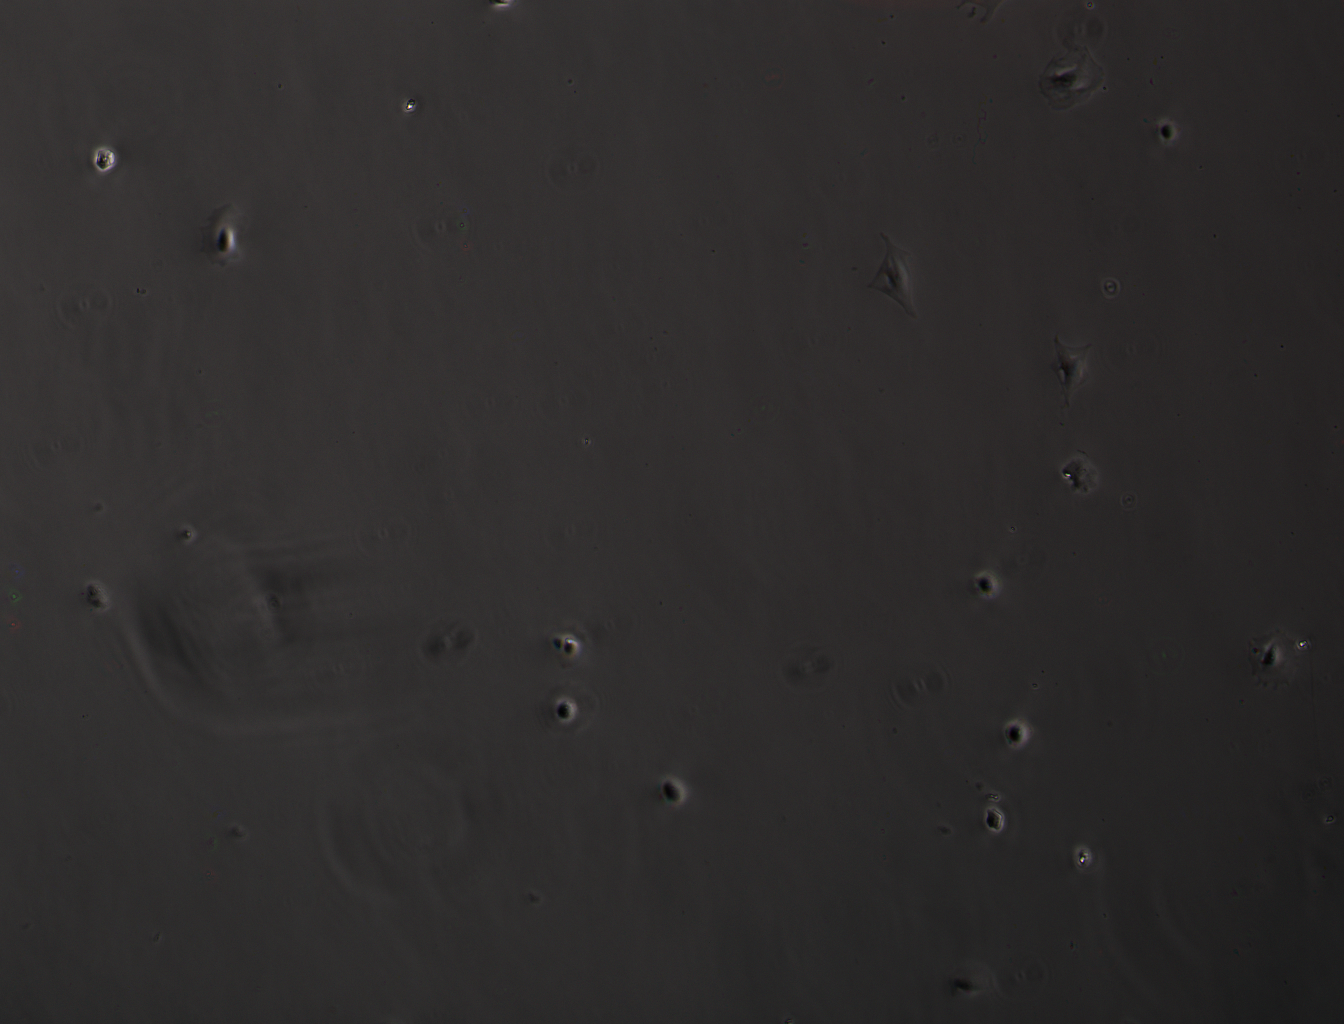

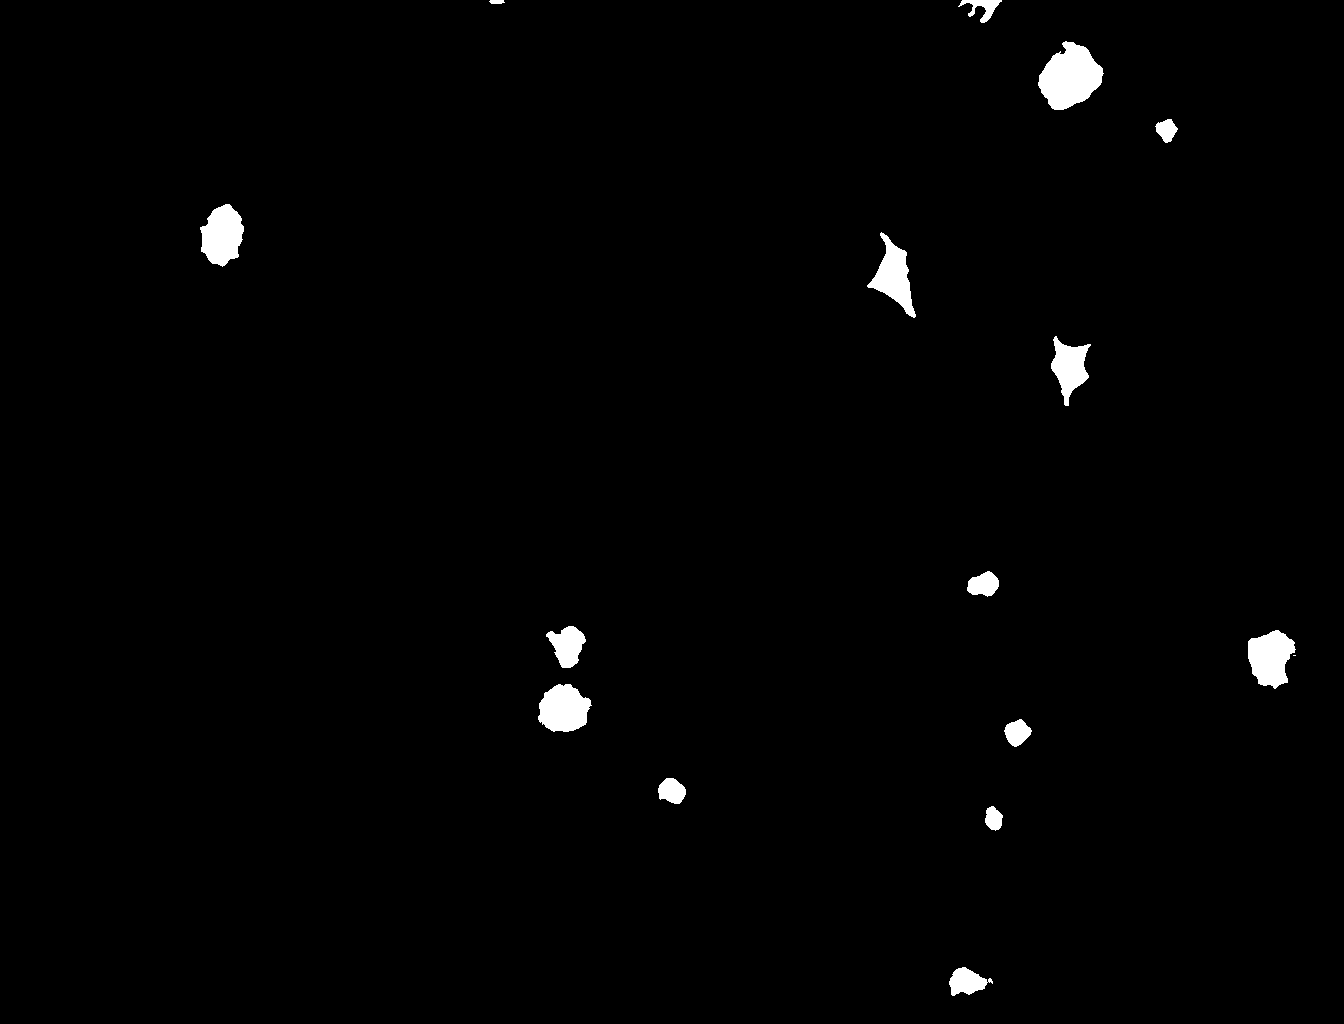

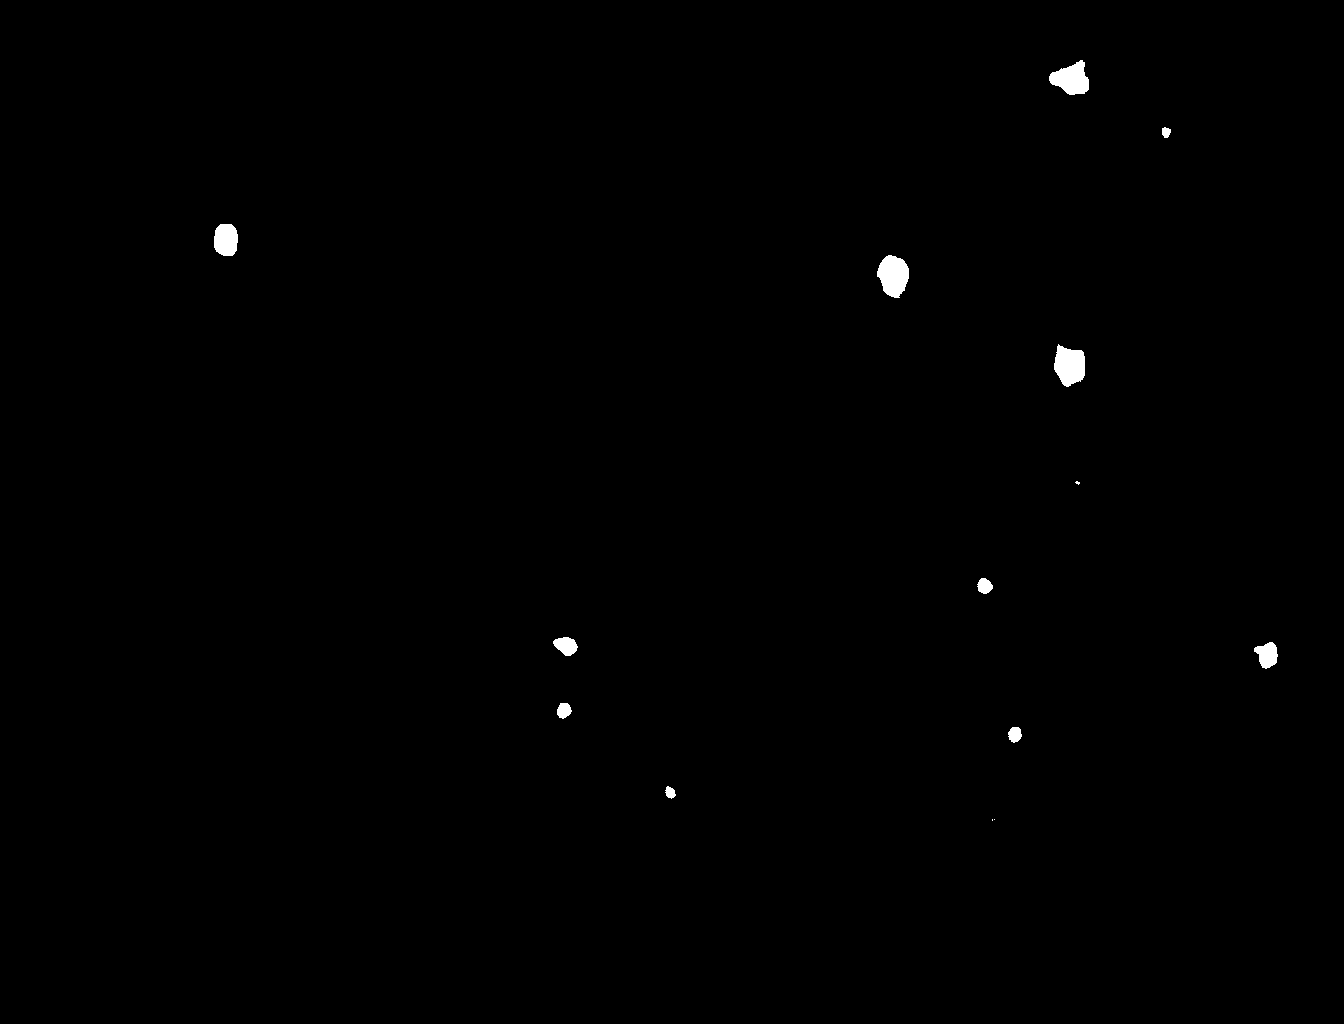

In [104]:

# Display results for validation image #i
i = random.randint(0,len(val_sequence.input_img_paths)-1)
# i = 0
print(i)

# Display input image
display(ImageOps.autocontrast(Image.open(val_sequence.input_img_paths[i])))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_sequence.target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)

## Save Model weights, config

In [105]:
save_model(outmodelname,model)

local\models->temp\models\keras
temp\models\keras gs:\optotaxisbucket\models\keras


# Segment Experiment
Will process each folder and subfolder individually. Works great with large numbers of images split into subfolders (like stage positions) and with small numbers of images in the main folder. Pulls data from google drive.

### Loading a trained model

In [191]:
model = load_model(segment_model_name)
model.compile(
    optimizer="rmsprop",
    loss=None,
)
model.summary()
keras.backend.clear_session()
model = model.cuda()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)             │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_data (BatchNormalization)  │ (None, None, None, 3)     │               9 │ data[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, None, None, 3)     │               0 │ bn_data[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv0 (Conv2D)                │ (None, None, None, 64)    │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn0 (BatchNormalization)      │ (None, None, None, 64)    │             256 │ conv0[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relu0 (Activation)            │ (None, None, None, 64)    │               0 │ bn0[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, None, None, 64)    │               0 │ relu0[0][0]                │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooling0 (MaxPooling2D)       │ (None, None, None, 64)    │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn1              │ (None, None, None, 64)    │             256 │ pooling0[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu1            │ (None, None, None, 64)    │               0 │ stage1_unit1_bn1[0][0]     │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, None, None, 64)    │               0 │ stage1_unit1_relu1[0][0]   │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_conv1 (Conv2D)   │ (None, None, None, 64)    │          36,864 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn2              │ (None, None, None, 64)    │             256 │ stage1_unit1_conv1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu2            │ (None, None, None, 64)    │               0 │ stage1_unit1_bn2[0][0]     │
│ (Activation)                  │                           │               

 Total params: 24,456,299 (93.29 MB)

 Trainable params: 24,438,949 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

### Prepare Images for segmentation

In [192]:
comp_fns = [];

if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

if do_scaling:
  comp_fns.append(create_scale_image_process_fn(scale_factor))

im_comp_fns = [prepare_image,*comp_fns];

if image_stacking:
    im_comp_fns.insert(0,create_stack_adjacents())

im_proc_fn = compose_proc_functions(im_comp_fns)
process_segmentation_images(im_proc_fn);

C:\Users\miner\AppData\Local\Temp\ipykernel_15800\2327563780.py:234: UserWarning: non-image file in segmentation_images dir: p.nd                                             | 0/2024 [00:00<?, ?it/s]
  warn(f"non-image file in {keyword} dir: {im}");
  0%|                                                                                                                                                                         | 0/2024 [00:00<?, ?it/s]

Skipping image p_s1_t1.TIF which is missing an image adjacency p_s1_t0.TIF.


 10%|████████████████▌                                                                                                                                              | 211/2024 [01:49<13:54,  2.17it/s]

Skipping image p_s1_t289.TIF which is missing an image adjacency p_s1_t290.TIF.


 14%|██████████████████████▊                                                                                                                                        | 290/2024 [02:26<14:49,  1.95it/s]

Skipping image p_s2_t1.TIF which is missing an image adjacency p_s2_t0.TIF.


 25%|███████████████████████████████████████▎                                                                                                                       | 500/2024 [04:15<13:20,  1.90it/s]

Skipping image p_s2_t289.TIF which is missing an image adjacency p_s2_t290.TIF.


 29%|█████████████████████████████████████████████▍                                                                                                                 | 579/2024 [04:57<12:50,  1.88it/s]

Skipping image p_s3_t1.TIF which is missing an image adjacency p_s3_t0.TIF.


 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 789/2024 [06:48<10:58,  1.88it/s]

Skipping image p_s3_t289.TIF which is missing an image adjacency p_s3_t290.TIF.


 43%|████████████████████████████████████████████████████████████████████▏                                                                                          | 868/2024 [07:30<10:12,  1.89it/s]

Skipping image p_s4_t1.TIF which is missing an image adjacency p_s4_t0.TIF.


 53%|████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1078/2024 [09:18<07:53,  2.00it/s]

Skipping image p_s4_t289.TIF which is missing an image adjacency p_s4_t290.TIF.


 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1157/2024 [09:58<07:24,  1.95it/s]

Skipping image p_s5_t1.TIF which is missing an image adjacency p_s5_t0.TIF.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1367/2024 [11:45<05:37,  1.95it/s]

Skipping image p_s5_t289.TIF which is missing an image adjacency p_s5_t290.TIF.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1446/2024 [12:24<04:54,  1.96it/s]

Skipping image p_s6_t1.TIF which is missing an image adjacency p_s6_t0.TIF.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1656/2024 [14:11<03:04,  1.99it/s]

Skipping image p_s6_t289.TIF which is missing an image adjacency p_s6_t290.TIF.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1735/2024 [14:51<02:26,  1.97it/s]

Skipping image p_s7_t1.TIF which is missing an image adjacency p_s7_t0.TIF.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1945/2024 [16:38<00:40,  1.95it/s]

Skipping image p_s7_t289.TIF which is missing an image adjacency p_s7_t290.TIF.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2024/2024 [17:18<00:00,  1.95it/s]


In [193]:
#@title Prepare file paths and calculate remaining segmentation required
## Complicated procedure; ensures that the directory structure is fully copied from the input
## Has to broadcast over potentially multiple output folders

## prepare input file reading
subfolders = [ Path(f.path) if f.is_dir() else None for f in os.scandir(segmentation_images_folder)  ]
toplevel_images = False;
if None in subfolders:
  subfolders = [s for s in subfolders if s is not None];
  toplevel_images = True;
corresponding_outs = [segmentation_output_folder];
if len(subfolders) == 0:
  subfolders = [segmentation_images_folder];
  toplevel_images = True;
else:
  corresponding_outs = [segmentation_output_folder/f.name for f in subfolders];
  if toplevel_images:
    subfolders.append(segmentation_images_folder);
    corresponding_outs.append(segmentation_output_folder);
  for c in corresponding_outs:
    if not(os.path.exists(c)):
      os.mkdir(c);

batchSize = 4;

folderChunks = [];
for f,out in zip(subfolders,corresponding_outs):
  print("pulling files from",os.path.basename(f))
  files = get_image_files(f);
  completed_masks = os.listdir(out);
  print("input files:",len(files))
  print("output files:",len(completed_masks))
  files = [fi for fi in files if os.path.basename(fi) not in completed_masks];
  print("remaining files:",len(files))

  folderChunks.append(SegmentationSequence(batchSize,None,files));


pulling files from segmentation_images
input files: 2009
output files: 0
remaining files: 2009


### Segment images

In [194]:
for fileChunks,outFolder,f in zip(folderChunks,corresponding_outs,subfolders):
    print("in:",os.path.basename(f),"out:",os.path.basename(outFolder),"count:",len(fileChunks));
    for i in tqdm(range(len(fileChunks))): #segmentation sequence won't do stopiteration for whatever reason
        chunk,paths = fileChunks[i]
        pred = model.predict(chunk,verbose=(len(fileChunks) <= 1))
        predictions = keras.ops.argmax(pred,-1).cpu() #convert parallel confidences to label index
        for path,prediction in zip(paths,predictions):
            basename = os.path.basename(path);
            im = prediction.numpy().astype('uint8');
            imsave(outFolder/basename,im,check_contrast=False);
    with open(outFolder/'segmentation_complete.flag','w') as f:
        pass;
    print("folder processing complete");

in: segmentation_images out: segmentation_masks_out count: 503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [1:00:26<00:00,  7.21s/it]

folder processing complete


### Deprocess and Export Masks

In [195]:
comp_fns = [no_op];

if segmentation_mask_scale_factor != 1:
  comp_fns.append(create_scale_image_process_fn(segmentation_mask_scale_factor))

if do_splitting:
  comp_fns.append(create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop));

mask_deproc_fn = compose_proc_functions(comp_fns)

deprocess_segmentation_masks(mask_deproc_fn);

checking prospective source gs:\optotaxisbucket\movie_segmentation\2024.6.27 OptoPLC FN+Peg Test 3\Cell
file/gcp found: requires temp folder


C:\Users\miner\AppData\Local\Temp\ipykernel_15800\2327563780.py:189: UserWarning: non-image file in segmentation_masks dir: segmentation_complete.flag███████████ | 1998/2010 [00:11<00:00, 205.92it/s]
  warn(f"non-image file in {keyword} dir: {im}");
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:11<00:00, 172.49it/s]

temp\segmentation_masks\Cell gs:\optotaxisbucket\movie_segmentation\2024.6.27 OptoPLC FN+Peg Test 3\Cell


/ [1.4k/3.4k files][  1.8 GiB/  4.4 GiB]  39% Done   9.5 MiB/s ETA 00:04:47     
-
Copying file://temp/segmentation_masks/Cell/p_s2_t49.TIF [Content-Type=image/tiff]...
- [1.4k/3.4k files][  1.8 GiB/  4.4 GiB]  39% Done   9.5 MiB/s ETA 00:04:47     
- [1.4k/3.4k files][  1.8 GiB/  4.4 GiB]  39% Done   9.4 MiB/s ETA 00:04:48     
Copying file://temp/segmentation_masks/Cell/p_s2_t5.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t50.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t51.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t52.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t53.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t54.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t55.TIF [Content-Type=image/tiff]...
Copying file://temp/segmentation_masks/Cell/p_s2_t56.TIF [Content-Ty